In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import train_set.csv
train_set = pd.read_csv('train_set.csv')

# Class distributions

<Axes: xlabel='orig_label'>

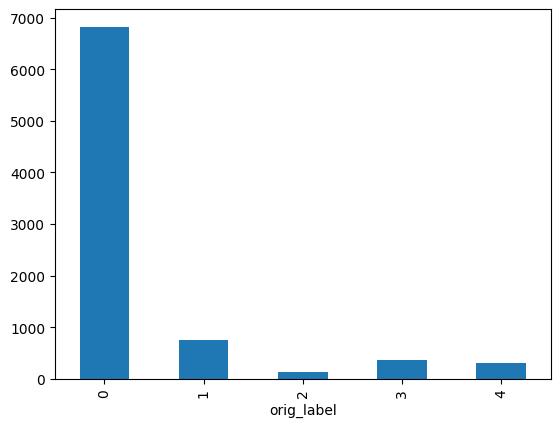

In [4]:
# Plot the distribution of orig_label, with the x-axis values in ascending order
orig_label_counts = train_set['orig_label'].value_counts()

orig_label_counts.sort_index().plot(kind='bar')


<Axes: xlabel='orig_label'>

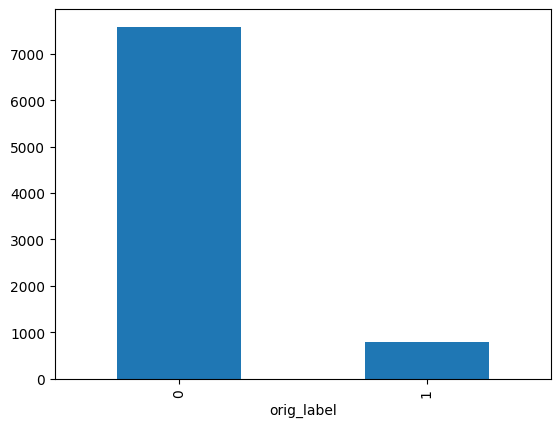

In [5]:
# 0,1 are non-PCL, 2,3,4 are PCL
train_set['orig_label'].replace({1: 0, 2: 1, 3: 1, 4: 1}).value_counts().sort_index().plot(kind='bar')

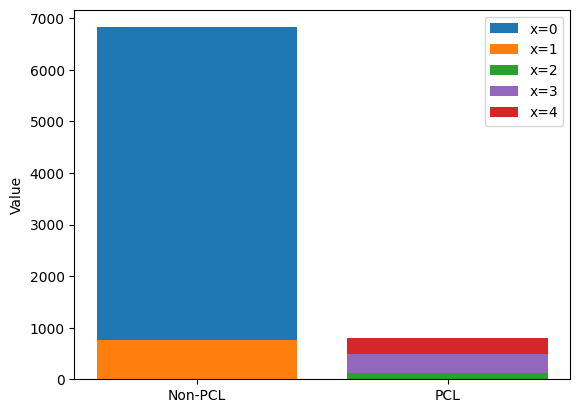

In [8]:
fig, ax = plt.subplots()

ys = [orig_label_counts.get(i, 0) for i in range(5)]

# Single bar at x=0
ax.bar(0, ys[0], label="x=0", color='tab:blue')

# Stacked bars at x=1
ax.bar(0, ys[1], label="x=1", color='tab:orange')
ax.bar(1, ys[2], label="x=2", color='tab:green')
ax.bar(1, ys[3], bottom=ys[2], label="x=3", color='tab:purple')
ax.bar(1, ys[4], bottom=ys[2]+ys[3], label="x=4", color='tab:red')

# Labels and legend
ax.set_xticks([0, 1])
ax.set_xticklabels(["Non-PCL", "PCL"])
ax.set_ylabel("Value")
ax.legend()

# Show plot
plt.show()

# Text Lengths

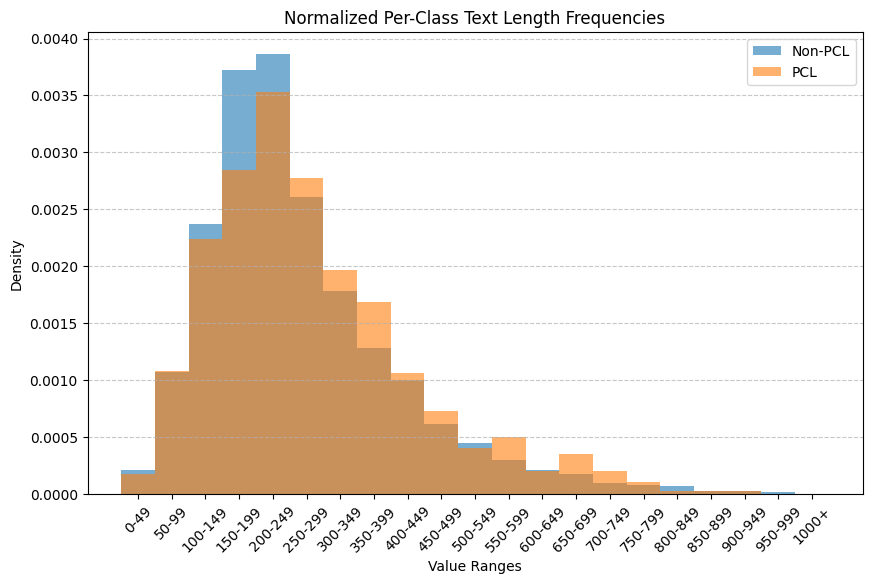

In [9]:
# Get the text lengths for each class
pcl_lengths = train_set[train_set['label'] == 1]['text'].str.len()
non_pcl_lengths = train_set[train_set['label'] == 0]['text'].str.len()

# Last bin captures all 1000+
bin_edges = [i for i in range(0, 1001, 50)] + [int(max(np.max(pcl_lengths), np.max(non_pcl_lengths))) + 1]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist([non_pcl_lengths], bins=bin_edges, width=50, density=True, alpha=0.6, label=['Non-PCL'])
plt.hist([pcl_lengths], bins=bin_edges, width=50, density=True, alpha=0.6, label=['PCL'])

# Labels and legend
x_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)}" for i in range(len(bin_edges)-2)] + ["1000+"]
# x_labels = [int(bin_edges[i]) for i in range(1, len(bin_edges)-1)] + ["1000+"]
plt.xticks(ticks=[(50 * i - 25) for i in range(1, len(bin_edges))], labels=x_labels, rotation=45)
plt.xlabel("Value Ranges")
plt.xlim(-50, 1100)
plt.ylabel("Density")
plt.title("Normalized Per-Class Text Length Frequencies")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

# Common phrases

In [13]:
# Find the most common bigrams in the PCL and non-PCL classes
from sklearn.feature_extraction.text import CountVectorizer

def most_common_ngrams(texts, n):
    # Create vectorizer
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')

    # Fit and transform the texts
    X = vectorizer.fit_transform(texts)

    # Get feature names (N-grams) and their frequencies
    ngram_freq = X.toarray().sum(axis=0)
    ngrams = vectorizer.get_feature_names_out()

    # Sort and return the most common N-grams
    sorted_ngrams = sorted(zip(ngrams, ngram_freq), key=lambda x: x[1], reverse=True)
    return sorted_ngrams

# Find the most common bigrams in the PCL and non-PCL classes
pcl_texts = train_set[train_set['label'] == 1]['text']
non_pcl_texts = train_set[train_set['label'] == 0]['text']

print("PCL most common bigrams:")
for ngram, freq in most_common_ngrams(pcl_texts, 2)[:10]:
    print(f"{ngram}: {freq}")

print("\nNon-PCL occurrences of above bigrams:")
for ngram, pcl_freq in most_common_ngrams(pcl_texts, 2)[:10]:
    non_pcl_freq = sum(1 for text in non_pcl_texts if ngram in text)
    print(f"{ngram}: {non_pcl_freq}")


PCL most common bigrams:
poor families: 112
people need: 26
homeless people: 24
children poor: 19
help need: 16
men women: 11
year old: 11
disabled people: 10
hundreds thousands: 10
vulnerable people: 9

Non-PCL occurrences of above bigrams:
poor families: 609
people need: 2
homeless people: 83
children poor: 0
help need: 0
men women: 0
year old: 11
disabled people: 86
hundreds thousands: 0
vulnerable people: 40
